In [118]:
%load_ext autoreload
%autoreload 2
from logistic_kernel import KernelLogisticRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[logistic_kernel.py](https://github.com/CameronHudson813/CameronHudson813.github.io/blob/main/posts/%20Sparse%20Kernel%20Machines/logistic_kernel.py)

# Abstract
Within this blog post I implement a kernelized logisitic regression model and perform various demonstrations to show how its behavior (making decision boundaries) changes based on its parameters. The experiments I preform is how the decision boundary created by the model changes based on its `γ` parameter, `λ`

# Positive-definite Kernel Function Definition
Now that we have created a kernelized logistic regression (implementation in `logistic_kernel.py`), we need some kernel function to test our implementation. For this, I will define one of the most widely utilized kernel functions, the RBF kernel, down below:

In [10]:
import torch
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

# Creating Classification Data
As this is a logistic regression model, its performance is best demonstrated on a binary classification problem. These two functions will create a 2d set of points belonging to 1 of 2 classes and plot the data we will be using to demonstrate kernelized logistic regression. 

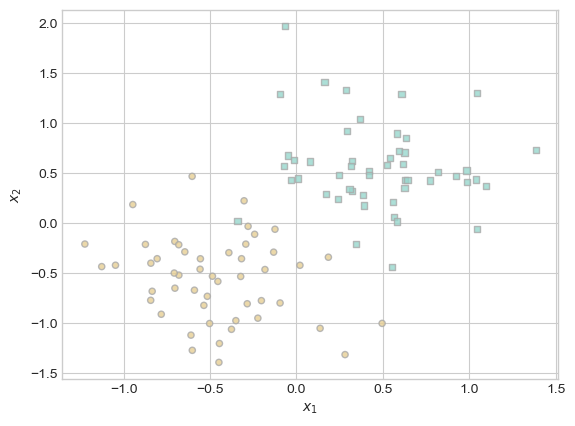

In [11]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

# Training Kernelized Logistic Regression
Now that we have our classification data, we can train our model on that data.

In [17]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

# Demonstrating Kernelized Logistic Regression on Data
Now that we have fully implemented our kernelized logistic regression and created a scatterplot data, we can demonstrate how the model fits to the data.

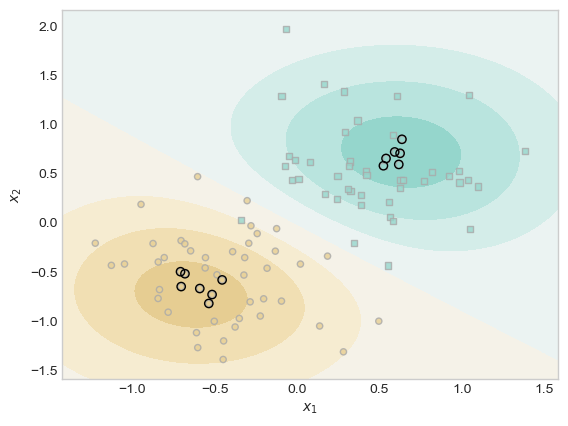

In [21]:
ix = (torch.abs(KR.a) > 0.001).squeeze() 

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

# Results
Through the filled contour lines, we see the model's predictions of what class the points are in. We see demonstrated in the plot, this kernelized logistic regression implementation does a good job at fitting to this data.

# Experiments
We will use our implmentation of kernelized logistic regression in a variety of ways to demonstrate how its behavior changes based on changes to its hyperparameters.

## 1: λ Is Large
The `λ` value controls how strong l2 regularization is in this kernelized logistic regression model, which is a method of penalizing large weights. With a large enough `λ` value, weights that do not significantly lower the objective loss function are pushed to a value of 0. In the experiment below, I show how a large enough λ value can result in all weights being driven to 0 by l2 regularization expect for 1 point, which is outlined in black.

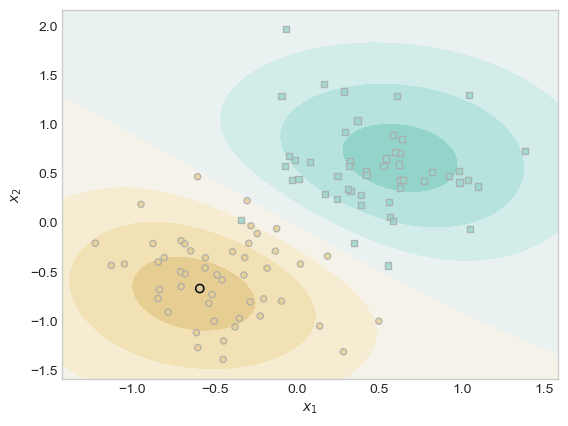

In [59]:
KR = KernelLogisticRegression(rbf_kernel, lam = 163, gamma = 1)
KR.fit(X, y, m_epochs = 50000, lr = 0.01)

ix = (torch.abs(KR.a) > 0.001).squeeze() 

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

## 2: Changing γ
The `γ` value within kernelized logistic regression essentially controls how wide of an influence each point has in the decision boundary, with the width decreasing as `γ` increases. As the experiment below demonstrates, the decision boundary is smoother when `γ` is low, as points far from each other have a larger influence on the decision function. Larger `γ` values however signal that only points close to each other have a strong influence on the overall shape of the decision boundary, making the model more prone to fitting to noise and having a decision boundary that perfectly wraps around the training data. 

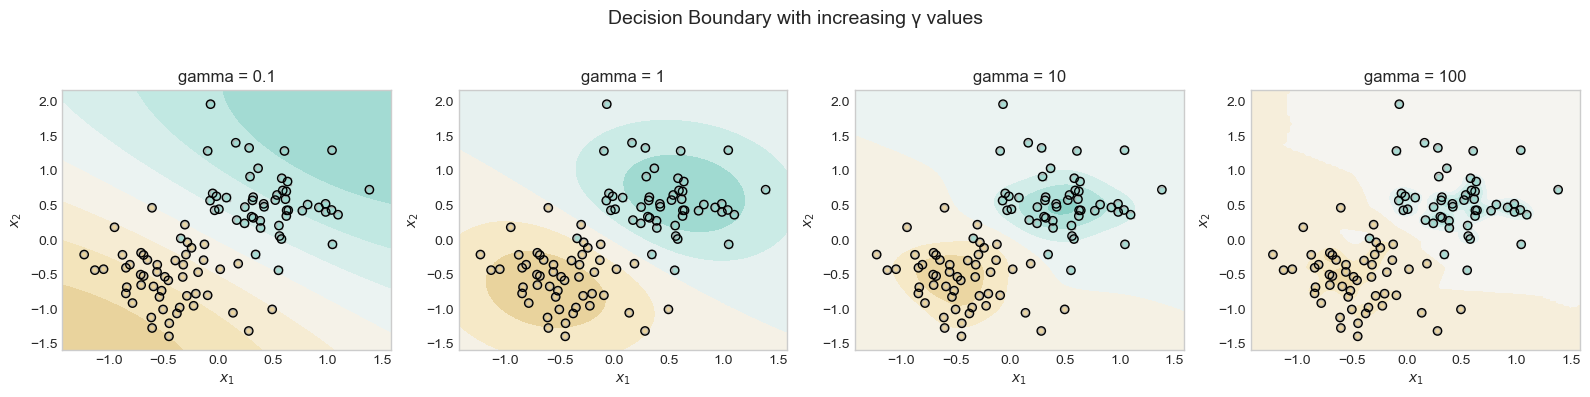

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
plt.suptitle("Decision Boundary with increasing γ values", fontsize=14)
gamma = [0.1, 1, 10, 100]

for i in range(4):
    KR = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=gamma[i])
    KR.fit(X, y, m_epochs=50000, lr=0.01)

    ix = (torch.abs(KR.a) > 0.001).squeeze()

    x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
    x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    X_ = torch.stack((X1.ravel(), X2.ravel()), dim=1)

    preds = KR.score(X_, recompute_kernel=True).reshape(X1.shape)

    ax[i].contourf(X1, X2, preds, origin="lower", cmap="BrBG",
                   vmin=2 * preds.min() - preds.max(), vmax=2 * preds.max() - preds.min())
    plot_classification_data(X, y, ax[i])
    ax[i].scatter(X[ix, 0], X[ix, 1], facecolors="none", edgecolors="black")
    ax[i].set_title(f"gamma = {gamma[i]}")

fig.tight_layout(rect=[0, 0, 1, 0.95])

## 3: Kernel Methods on Nonlinear Patterns
In order to demonstrate how kernelized logistic regression can fit to nonlinear data, in the experiment below we will generate a 2d set of nonlinear data with sklearn's `make_moons`, using the `plot_decision_regions` function to show the decision boundary that is creating by this kernelized logistic regression implementation. 

In [86]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from mlxtend.plotting import plot_decision_regions

X_np, y_np = make_moons(n_samples=200, noise=0.2, random_state=42)

# Step 2: Convert to PyTorch tensors
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

# Step 3: Fit the model
KR = KernelLogisticRegression(rbf_kernel, lam=0.001, gamma=1)
KR.fit(X, y, m_epochs=500000, lr=0.001)


<Axes: >

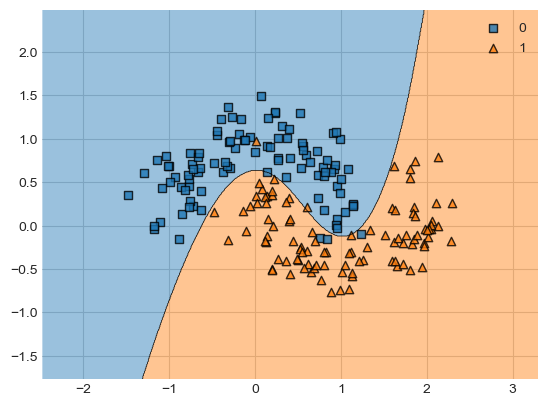

In [87]:
fig, ax = plt.subplots(1, 1)
plot_decision_regions(X_np, y_np, clf = KR, ax = ax)

# Results
As demonstrated, by tweaking this kernelized logistic regression `γ` and `λ` values, the model is able to create a decision boundary that almost perfectly seperates nonlinear data. 

# Overfitting Demonstration
We will generate two datasets, one for testing and one for training, and demonstrate how overfitting can occur in a kernelized logistic regression model when a suboptimal `γ` is picked.

# Generating Data
In this block of code, we will use the same function with the same parameters `make_moons` to generate a training and testing dataset.

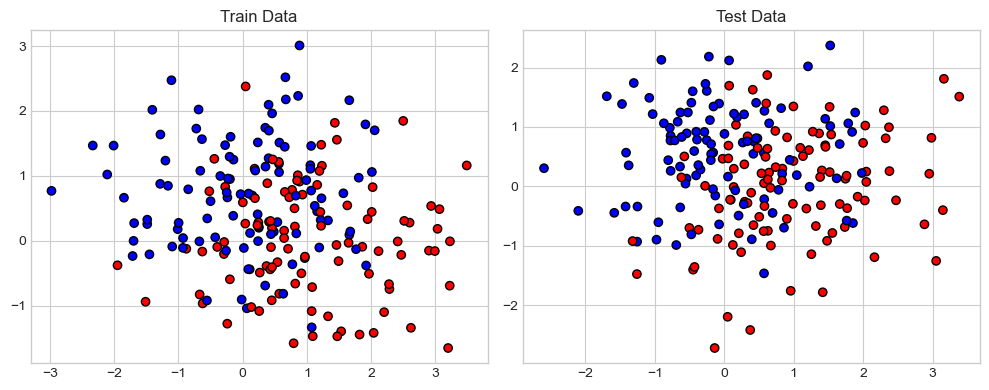

In [111]:
X_train, y_train = make_moons(n_samples=200, noise=0.8, random_state=42)
X_test, y_test = make_moons(n_samples=200, noise=0.8, random_state=20)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolors='k')
ax[0].set_title("Train Data")

ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', edgecolors='k')
ax[1].set_title("Test Data")

plt.tight_layout()
plt.show()

# ROC Curves to Visualize Overfitting
An ROC (Receiver Operating Characteristic) curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds. It is a usful tool to assess the performance of a binary classifier, and we will use this to see model's performance on the training dataset and testing dataset simultaneously.

Text(0.5, 1.0, 'ROC Curve - High Gamma (γ=1000)')

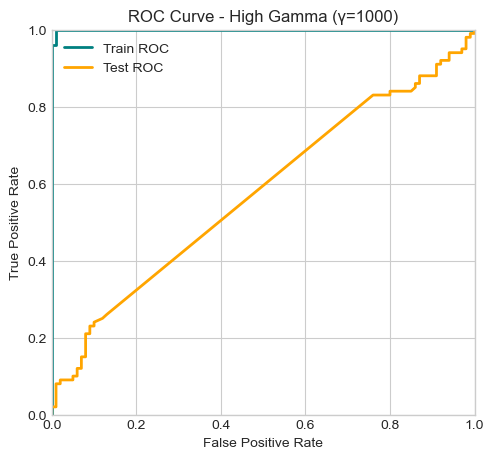

In [116]:
from sklearn.metrics import roc_curve
KR_high_gamma = KernelLogisticRegression(rbf_kernel, lam=0.01, gamma=1000)
KR_high_gamma.fit(X_train_tensor, y_train_tensor, m_epochs=5000, lr=0.01)

y_train_pred_high = KR_high_gamma.predict_proba(X_train)
y_test_pred_high = KR_high_gamma.predict_proba(X_test)
fpr_train_high, tpr_train_high, _ = roc_curve(y_train, y_train_pred_high)
fpr_test_high, tpr_test_high, _ = roc_curve(y_test, y_test_pred_high)

# Plot ROC curves
plt.figure(figsize=(12, 5))

# High gamma (overfitting) ROC plot
plt.subplot(1, 2, 1)
plt.plot(fpr_train_high, tpr_train_high, color='teal', lw=2, label="Train ROC")
plt.plot(fpr_test_high, tpr_test_high, color='orange', lw=2, label="Test ROC")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve - High Gamma (γ=1000)')

# Results
Because of the large `γ` value, the train ROC curve illustrates that the model is fit perfectly to the training dataset, but has an accuracy of approximately `50%` on the training data, demonstrating how a suboptimal `γ` value can result in overfitting.

# Conclusion
With this blog post, I learned how to implement kernelized logistic regression and how changes to its hyperparameters can result in changes to its decision boundaries and overall model proformance.